# Mixture model tests

Trying out some mixture modeling with `numpyro`

In [513]:
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
from numpyro.contrib.funsor import config_enumerate

import numpy as np
from numpy.random import default_rng
import pandas as pd

import seaborn as sns

from jax.scipy.special import logit, expit

def logistic(r):
    return 1 / (1 + jnp.exp(-r))

# generating some data

I'll make it really obvious there's a mixture going on.

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

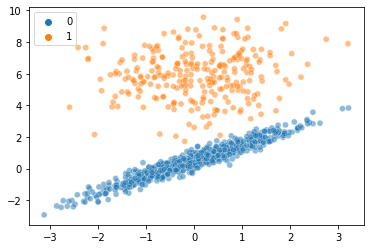

In [1017]:
n_obs = 1000
rg = default_rng(12345)

x = rg.normal(0,1,n_obs)
bad = rg.binomial(1, .25, n_obs)
noise = rg.normal(6, 1.5, n_obs)
y_true = rg.normal(.5 + 1*x, .3, n_obs)
y_obs = np.where(bad==1, noise, y_true)

sns.scatterplot(x, y_obs, hue=bad,alpha=.5)

# Mixture with discrete latents

This is the numpyronic way of doing things when there are only a handful of discrete states. It can also do enumeration across them, but it doesn't generate posterior probabilities for all sites correctly (yet) so you can't do things like posterior predictive checks with `arviz`.

See these github issues:

* https://github.com/pyro-ppl/numpyro/issues/770
* https://github.com/pyro-ppl/numpyro/issues/857
* https://github.com/pyro-ppl/numpyro/issues/889


In [327]:
# @config_enumerate # don't need this when doing DiscreteHMCGibbs
def mixmodel(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    mean_outlier = numpyro.sample("mean_o", dist.Normal(0,10))
    sigma_outlier = numpyro.sample("sigma_o", dist.HalfCauchy(10))
    p_outlier = numpyro.sample("p_outlier", dist.Dirichlet(jnp.ones(2)))

    y_fore = alpha + beta*x
    
    with numpyro.plate("data", x.shape[0]):
        z = numpyro.sample("z", dist.Categorical(p_outlier))
        yhat = jnp.select([z==0, z==1], [y_fore, mean_outlier] )
        mix_sigma = jnp.select([z==0, z==1], [sigma, sigma_outlier])
        numpyro.sample("yhat", dist.Normal(yhat, mix_sigma), obs=y)


In [22]:
kernel = DiscreteHMCGibbs(NUTS(mixmodel), modified=True)
mcmc_test = MCMC(kernel, 1000, 1000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)

sample: 100%|██████████| 2000/2000 [00:13<00:00, 146.65it/s, 7 steps of size 6.75e-01. acc. prob=0.92]


In [24]:
posterior_samples = mcmc_test.get_samples()

posterior_predictive = Predictive(mixmodel, posterior_samples)(
    random.PRNGKey(1), x
)
prior = Predictive(mixmodel, num_samples=500)(
    random.PRNGKey(10), x
)

az_data = az.from_numpyro(mcmc_test, prior=prior, posterior_predictive=posterior_predictive)

In [28]:
az.summary(az_data, var_names=["~z"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.501,0.011,0.479,0.522,0.000,0.000,1527.0,650.0,NaN
beta,1.001,0.011,0.981,1.024,0.000,0.000,1520.0,587.0,NaN
mean_o,5.886,0.100,5.704,6.079,0.003,0.002,1293.0,747.0,NaN
p_outlier[0],0.731,0.014,0.704,0.758,0.000,0.000,1317.0,837.0,NaN
p_outlier[1],0.269,0.014,0.242,0.296,0.000,0.000,1317.0,837.0,NaN
sigma,0.300,0.008,0.284,0.315,0.000,0.000,1240.0,908.0,NaN
sigma_o,1.558,0.074,1.407,1.686,0.002,0.002,963.0,660.0,NaN


<AxesSubplot:xlabel='yhat'>

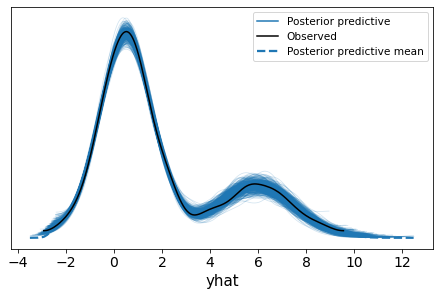

In [12]:
az.plot_ppc(data=az_data, data_pairs={"yhat":"yhat"}, num_pp_samples=500)

## Implementing custom distribution

This mixture is simple enough we don't need the discrete latents and can marginalize them out. To do so, I create a custom distribution. This should scale better to an arbitrary number of mixture distributions. And it lets you use vanilla NUTS sampling without any funny stuff.

BUT! Something is wrong as this doesn't work properly with multiple chains. Must be because i am manually managing the shapes of inputs and not doing so in a safe enough way. I'm not sure if the problem is happening inside my custom distribution function or in the model code. 

__Probably not worth fixing at this stage.__

<AxesSubplot:ylabel='Count'>

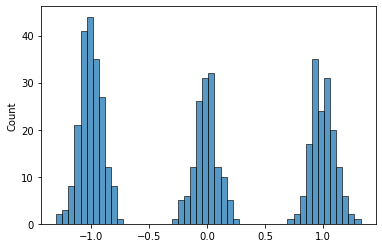

In [1086]:
import numpyro.distributions.constraints as constraints
from numpyro.distributions.util import promote_shapes, is_prng_key, validate_sample
from jax import lax
import jax

class MixtureNormal(dist.distribution.Distribution):
    '''Mixture of Normal distribtions with marginalized latents
    
    Takes loc and scale parameters for normal distributions along with a simplex mixing_probs parameter that defines the mixture probabilities. 
    '''
    arg_constraints = {
        'loc': constraints.real, 
        'scale': constraints.positive, 
        'mixing_probs': constraints.simplex
    }
    support = constraints.real
    reparametrized_params = ['loc', 'scale', 'mixing_probs']

    def __init__(self, loc=0., scale=1., mixing_probs=1., validate_args=None):
        self.loc, self.scale = promote_shapes(loc, scale)
        self.mixing_probs = jnp.reshape(mixing_probs, (1,-1))
        batch_shape = lax.broadcast_shapes(jnp.shape(loc), jnp.shape(scale))
        super(MixtureNormal, self).__init__(batch_shape=batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()): # fixed dimensionality 4/16/21, 12:23 PM ?
        assert is_prng_key(key)
        mixing_logits = jax.scipy.special.logit(self.mixing_probs)
        ind = random.categorical(key, mixing_logits.squeeze(), shape = sample_shape  + self.event_shape)
        eps = random.normal(key, shape=sample_shape  + self.event_shape) # removed + self.batch_shape 
        return self.loc[ind] + eps * self.scale[ind]
        # return ind

    @validate_sample
    def log_prob(self, value):
        log_mixing_probs = jnp.log(self.mixing_probs.T)
        probs = dist.Normal(self.loc, self.scale).log_prob(value)
        sum_probs = jnp.add(log_mixing_probs, probs)
        
        return jax.nn.logsumexp(sum_probs, axis=0)

MixtureNormal(jnp.array([0,1,-1]), jnp.array([.1,.1,.1]), jnp.array([.3,.3,.4])).sample(random.PRNGKey(1), (10,))
z = MixtureNormal(
    jnp.tile(jnp.array([0,1,-1]),5), 
    jnp.tile(jnp.array([.1,.1,.1]),5), 
    jnp.array([.3,.3,.4])
).sample(random.PRNGKey(1), (500,))

sns.histplot(x=z,bins=50)

In [1018]:
def mixmodel_custom(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    mean_outlier = numpyro.sample("mean_o", dist.Normal(0,10))
    sigma_outlier = numpyro.sample("sigma_o", dist.HalfCauchy(10))
    p_outlier = numpyro.sample("p_outlier", dist.Dirichlet(jnp.ones(2)))

    y_fore = alpha + beta*x

    ## have to manually manage shapes of things
    yhat = jnp.stack([y_fore, mean_outlier.repeat(x.shape[0])])
    mix_sigma = jnp.stack([sigma.repeat(x.shape[0]), sigma_outlier.repeat(x.shape[0])])

    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("yhat", MixtureNormal(yhat, mix_sigma, p_outlier), obs=y)

In [1019]:
kernel = NUTS(mixmodel_custom)
mcmc_test = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc_test.run(random.PRNGKey(0), x, y_obs)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 624.46it/s, 7 steps of size 6.71e-01. acc. prob=0.92] 


In [1020]:
posterior_samples = mcmc_test.get_samples()

posterior_predictive = Predictive(mixmodel, posterior_samples)(
    random.PRNGKey(1), x
)
prior = Predictive(mixmodel, num_samples=500)(
    random.PRNGKey(10), x
)

az_data = az.from_numpyro(mcmc_test, prior=prior, posterior_predictive=posterior_predictive)

In [1021]:
az.summary(az_data)

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.501,0.011,0.480,0.523,0.000,0.000,2801.0,1504.0,NaN
beta,1.002,0.011,0.980,1.022,0.000,0.000,3230.0,1547.0,NaN
mean_o,5.887,0.096,5.697,6.059,0.002,0.001,3089.0,1550.0,NaN
p_outlier[0],0.731,0.014,0.705,0.759,0.000,0.000,2684.0,1247.0,NaN
p_outlier[1],0.269,0.014,0.241,0.295,0.000,0.000,2684.0,1247.0,NaN
sigma,0.300,0.008,0.285,0.316,0.000,0.000,2805.0,1414.0,NaN
sigma_o,1.557,0.077,1.423,1.704,0.001,0.001,2744.0,1445.0,NaN


<AxesSubplot:xlabel='yhat'>

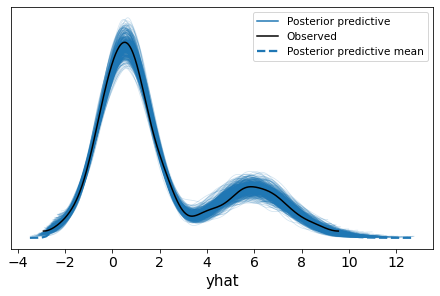

In [1022]:
az.plot_ppc(data=az_data, data_pairs={"yhat":"yhat"}, num_pp_samples=500)

In [ ]:
## this works with multiple chains but is very slow and creates a bunch of extra stuff you don't need.
# def mixmodel_custom(x, y=None):
    
#     alpha = numpyro.sample("alpha", dist.Normal(0,10))
#     beta = numpyro.sample("beta", dist.Normal(0,10))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10)).expand([x.shape[0]])
    
#     mean_outlier = numpyro.sample("mean_o", dist.Normal(0,10).expand([x.shape[0]]))
#     sigma_outlier = numpyro.sample("sigma_o", dist.HalfCauchy(10).expand([x.shape[0]]))
#     p_outlier = numpyro.sample("p_outlier", dist.Dirichlet(jnp.ones(2)))

#     y_fore = alpha + beta*x

#     ## have to manually manage shapes of things
#     yhat = jnp.stack([y_fore, mean_outlier])
#     mix_sigma = jnp.stack([sigma, sigma_outlier])

#     with numpyro.plate("data", x.shape[0]):
#         numpyro.sample("yhat", MixtureNormal(yhat, mix_sigma, p_outlier), obs=y)

# Beta mixture (drawn to .50)

A lot of Ps are drawn to say .50 if they either are uncertain, or if their answer is at all close to .50. There are two plausible models of this, one is that people are drawn to round to .50 even if they are more than 5 or 10 values away. The other is they use .50 to signal "50-50" or complete uncertainty. For our purposes I don't know that these should be treated differently, so I will just iplement the rounding model.

We'll say that the rounding has happened if out of 3 blocks they say 50 at least twice. Rounding to 50 from 10 away would produce an average within +/- 3.3 points of 50, and rounding from 20 away would make it +/- 6.6. So plausibly I think we could set the sd of responses rounded to 50 to 3.3 on a 100 pt scale. The probability that people do this would be propotional to the distnace their true answer is from 50. Informal grid search says that's equivalent to k of 220.


Update 3/30/21, 6:43 PM: Got this working now

0.1045


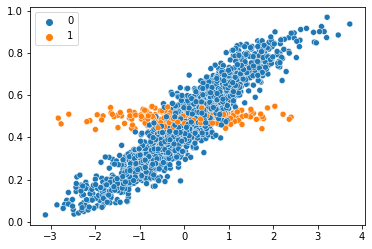

In [1122]:
n_obs = 2000
rg = default_rng(12345)

def x_drawn_p(x):
    distance = abs(x) 
    return logistic(-2 + 3*distance)

x = rg.normal(0,1,n_obs)
y_mean = logistic(-.2 + .8*x)

y = rg.beta(y_mean*50, (1-y_mean)*50, n_obs)
p_drawn = .1
drawn = rg.binomial(1, p_drawn, n_obs)
dist50 = rg.beta(.5*300, .5*300, n_obs) # k = 300
y_obs = np.where(drawn==1, dist50, y)
sns.scatterplot(x = x, y=y_obs, hue=drawn)
print(np.sum(drawn)/n_obs)

<AxesSubplot:ylabel='Count'>

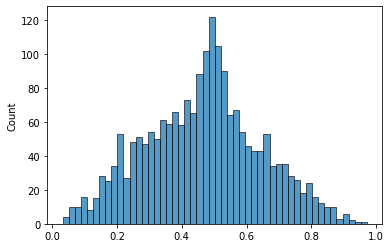

In [1123]:
sns.histplot(y_obs, bins=50)

In [591]:
# @config_enumerate # don't need this when doing DiscreteHMCGibbs
def mixmodel_beta(x, y_obs=None):
    
#     alpha_50 = numpyro.sample("alpha50", dist.Normal(0,3))
#     beta_50 = numpyro.sample("beta50", dist.Normal(0,3))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))

    alpha = numpyro.sample("alpha", dist.Normal(0,3))
    beta = numpyro.sample("beta", dist.Normal(0,3))
    drawn_p = numpyro.sample("drawn_p", dist.Beta(1,1))    
    
    mix_muval = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    mix_kval = numpyro.sample("mix_kval", dist.HalfCauchy(100))
    y_true = logistic(alpha + beta*x)

#     drawn_p = logistic(alpha_50 + beta_50*abs(logit(y_true)))
    
    with numpyro.plate("data", x.shape[0]):
        z = numpyro.sample("z", dist.Bernoulli(drawn_p))
        yhat = jnp.select([z==0, z==1], [y_true, mix_muval] )
        mix_k = jnp.select([z==0, z==1], [k, mix_kval])
        numpyro.sample("yhat", dist.Beta(yhat*mix_k, (1-yhat)*mix_k), obs=y_obs)


In [592]:
kernel = DiscreteHMCGibbs(NUTS(mixmodel_beta), modified=True)
mcmc_test = MCMC(kernel, 1000, 1000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)

sample: 100%|██████████| 2000/2000 [07:54<00:00,  4.21it/s, 7 steps of size 4.85e-01. acc. prob=0.91] 


In [593]:
import arviz as az

posterior_samples = mcmc_test.get_samples()

posterior_predictive = Predictive(mixmodel_beta, posterior_samples)(
    random.PRNGKey(1), x
)
prior = Predictive(mixmodel_beta, num_samples=500)(
    random.PRNGKey(10), x
)

az_data = az.from_numpyro(mcmc_test, prior=prior, posterior_predictive=posterior_predictive)
az.summary(az_data)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.200,0.008,-0.215,-0.186,0.000,0.000,991.0,587.0,NaN
beta,0.791,0.009,0.774,0.806,0.000,0.000,704.0,508.0,NaN
drawn_p,0.105,0.010,0.087,0.124,0.001,0.000,414.0,600.0,NaN
k,48.583,1.758,45.291,51.732,0.071,0.050,611.0,607.0,NaN
mix_kval,318.395,52.733,221.672,421.896,3.491,2.472,229.0,461.0,NaN
...,...,...,...,...,...,...,...,...,...
z[1995],0.010,0.100,0.000,0.000,0.003,0.002,886.0,886.0,NaN
z[1996],0.117,0.322,0.000,1.000,0.009,0.006,1362.0,1000.0,NaN
z[1997],0.234,0.424,0.000,1.000,0.010,0.007,1772.0,1000.0,NaN
z[1998],0.186,0.389,0.000,1.000,0.010,0.007,1389.0,1000.0,NaN


Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.498,0.003,0.492,0.504,0.0,0.0,477.0,719.0,NaN


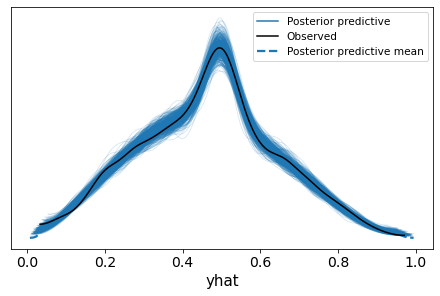

In [594]:
az.plot_ppc(data=az_data, data_pairs={"yhat":"yhat"}, num_pp_samples=500)
az.summary(az_data, var_names="mu")

# mixture of betas

Basic numeric and graphical tests below show the `log_prob()` method of the class works as expected.

In [1157]:
# all credit for this goes to @fehiepsi
# https://github.com/arviz-devs/arviz/issues/1661#issuecomment-821920203

class MixtureBeta(dist.Distribution):
    def __init__(self, concentration1, concentration0, mixing_probs, validate_args=None):
        expand_shape = jax.lax.broadcast_shapes(
            jnp.shape(concentration1), jnp.shape(concentration0), jnp.shape(mixing_probs))
        self._beta = dist.Beta(concentration1, concentration0).expand(expand_shape)
        self._categorical = dist.Categorical(jnp.broadcast_to(mixing_probs, expand_shape))
        super(MixtureBeta, self).__init__(batch_shape=expand_shape[:-1], validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        key, key_idx = random.split(key)
        samples = self._beta.sample(key, sample_shape)
        ind = self._categorical.sample(key_idx, sample_shape)
        return jnp.take_along_axis(samples, ind[..., None], -1)[..., 0]

    def log_prob(self, value):
        dirichlet_probs = self._beta.log_prob(value[..., None])
        sum_probs = self._categorical.logits + dirichlet_probs
        return jax.nn.logsumexp(sum_probs, axis=-1)

test_vec = jnp.array([.1,.2,.3,.4,.5])
mprob1 = .3
mprob2 = 1-mprob1

# mydist = MixtureBeta(
#     jnp.array([[30,5]]).T,
#       jnp.array([[10,20]]).T,
#     jnp.array([mprob1, mprob2])                          
# )

mydist = MixtureBeta(
    jnp.array([[30,5]]),
    jnp.array([[10,20]]),
    jnp.array([mprob1, mprob2])                          
)

## the mixture model returns what you'd expect

print(mydist.log_prob(test_vec))
# print(dist.Beta(30,10).log_prob(test_vec))
# print(dist.Beta(5,20).log_prob(test_vec))
z = jnp.log(jnp.exp(dist.Beta(30,10).log_prob(test_vec)) * mprob1 + jnp.exp(dist.Beta(5,20).log_prob(test_vec))*mprob2)
print(z)

mydist.sample(random.PRNGKey(0), (10,))
# print(dist.Normal(0,1).sample(random.PRNGKey(0), sample_shape=(5)))

# inds = random.categorical(random.PRNGKey(0), jax.scipy.special.logit(jnp.array([.5,.5])), shape = (10,))
# jnp.array([30,5])[inds]

[ 0.6979305   1.2326424   0.31740493 -1.4604887  -3.7020664 ]
[ 0.69792676  1.2326385   0.3174011  -1.4604926  -3.702069  ]


DeviceArray([[0.22780754],
             [0.17971034],
             [0.72651803],
             [0.21184868],
             [0.11977131],
             [0.19493073],
             [0.6995866 ],
             [0.7373543 ],
             [0.2162061 ],
             [0.82186705]], dtype=float32)

<AxesSubplot:>

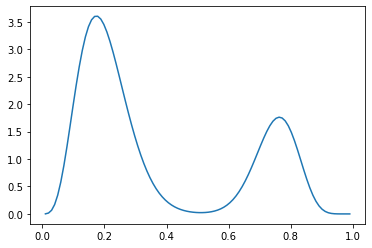

In [1159]:
## ok so that's a mixture distribution clearly 
# mydist = MixtureBeta(
#     jnp.array([[30,5]]),
#     jnp.array([[10,20]]),
#     jnp.array([.3,.7])                          
# )

z = np.linspace(.01,.99, num=100)
sns.lineplot(x = z, y = jnp.exp(mydist.log_prob(z)))

<AxesSubplot:ylabel='Count'>

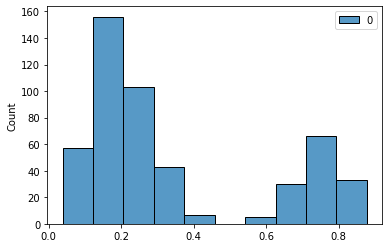

In [1160]:
# mydist = MixtureBeta(
#     jnp.array([[30,5]]),
#     jnp.array([[10,20]]),
#     jnp.array([.3,.7])                          
# )

sns.histplot(mydist.sample(random.PRNGKey(0), (500,)))

In [1161]:
# my munging inside the model is working as expected

yhat = jnp.stack([test_vec, jnp.ones(5)*.20], -1)
mix_k = jnp.stack([jnp.ones(5)*30, jnp.ones(5)*100], -1)

print(MixtureBeta(yhat*mix_k, (1-yhat)*mix_k, jnp.array([mprob1, mprob2])).log_prob(test_vec))
z = jnp.log(jnp.exp(dist.Beta(test_vec*30, (1-test_vec)*30).log_prob(test_vec)) * mprob1 + jnp.exp(dist.Beta(.20*100, .80*100).log_prob(test_vec))*mprob2)
print(z)


[0.82001567 2.1478276  0.5986514  0.28282875 0.26250935]
[0.82001567 2.1478274  0.59865135 0.28282878 0.26250938]


Passes these checks and recovers parameters! I was struggling with this b/c I was making a very stupid mistake and failing to pass the observation properly! SO it works as expected. Math FTW and so forth.

In [1152]:
def mixmodel_beta_custom(x, y_obs=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,3))
    beta = numpyro.sample("beta", dist.Normal(0,3))
    mixing_probs = numpyro.sample("mixing", dist.Dirichlet(jnp.ones(2)))
    
    k = numpyro.sample("k", dist.HalfCauchy(10))
    # mix_kval = numpyro.sample("mix_kval", dist.HalfCauchy(100))
    k_50 = numpyro.sample("k_50", dist.Normal(0,20))
    mix_kval = 300+k_50
    # mix_muval = numpyro.sample("mix_muval", dist.Beta(1,1))
    mix_muval = .5

    y_true = expit(alpha + beta*x)
    n_obs = y_true.shape[0]
    
    with numpyro.plate("data", x.shape[0]):
        # yhat = jnp.stack([y_true, jnp.ones(n_obs)*mix_muval])
        # mix_k = jnp.stack([jnp.ones(n_obs)*k, jnp.ones(n_obs)*mix_kval])
        yhat = jnp.stack([y_true, jnp.ones(n_obs)*mix_muval], -1)
        mix_k = jnp.stack([jnp.ones(n_obs)*k, jnp.ones(n_obs)*mix_kval], -1)
        numpyro.sample("yhat", MixtureBeta(yhat*mix_k, (1-yhat)*mix_k, mixing_probs), obs=y_obs)


In [1153]:
kernel = NUTS(mixmodel_beta_custom)
mcmc_test = MCMC(kernel, 2000, 2000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x, y_obs)

sample: 100%|██████████| 4000/4000 [01:01<00:00, 65.55it/s, 7 steps of size 7.20e-01. acc. prob=0.90]  


In [1154]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.20      0.01     -0.20     -0.21     -0.19   2521.71      1.00
      beta      0.79      0.01      0.79      0.78      0.81   1933.67      1.00
         k     48.62      1.74     48.64     45.76     51.44   2377.71      1.00
      k_50      2.70     18.27      2.61    -29.05     30.84   2245.74      1.00
 mixing[0]      0.89      0.01      0.89      0.88      0.91   2303.91      1.00
 mixing[1]      0.11      0.01      0.11      0.09      0.12   2303.91      1.00

Number of divergences: 0


<AxesSubplot:xlabel='yhat'>

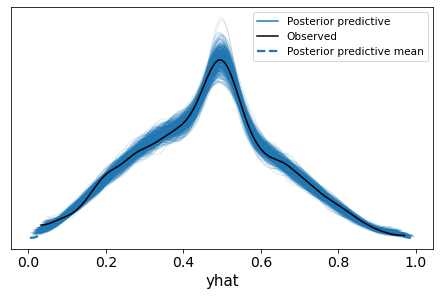

In [1155]:
posterior_samples = mcmc_test.get_samples()

posterior_predictive = Predictive(mixmodel_beta_custom, posterior_samples)(
    random.PRNGKey(1), x
)

prior = Predictive(mixmodel_beta_custom, num_samples=500)(
    random.PRNGKey(10), x
)

az_data2 = az.from_numpyro(mcmc_test, prior=prior, posterior_predictive=posterior_predictive)

az.plot_ppc(data=az_data2, var_names = "yhat", data_pairs={"yhat":"yhat"}, num_pp_samples=500)

This model recovers the right parameters but for some reason `arviz.plot_ppc()` function is broken when I use this custom distribution! I wonder if I am missing a method or something?

Filed an issue to try to get some help: https://github.com/arviz-devs/arviz/issues/1661


<AxesSubplot:>

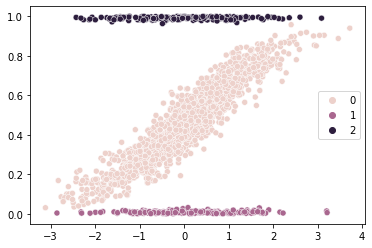

In [1180]:
n_obs = 2000
rg = default_rng(12345)

def x_drawn_p(x):
    distance = abs(x) 
    return logistic(-2 + 3*distance)

x = rg.normal(0,1,n_obs)
y_mean = logistic(-.2 + .8*x)

y = rg.beta(y_mean*50, (1-y_mean)*50, n_obs)
# p_drawn = .2 
# drawn = rg.binomial(2, p_drawn, n_obs)
drawn = rg.choice(np.array([0,0,0,0,0,0,0,0,1,2]), n_obs, replace=True)
dist1 = rg.beta(.01*300, .99*300, n_obs) # k = 300
dist99 = rg.beta(.99*300, .01*300, n_obs) # k = 300
y_obs = np.select([drawn==1, drawn==2], [dist1, dist99], y)
sns.scatterplot(x = x, y=y_obs, hue=drawn)
# print(np.sum(drawn)/n_obs)

<AxesSubplot:ylabel='Count'>

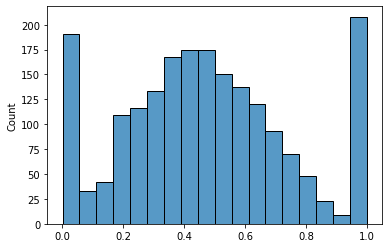

In [1181]:
sns.histplot(x = y_obs)

In [1192]:
def mixmodel_beta_custom3(x, y_obs=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,3))
    beta = numpyro.sample("beta", dist.Normal(0,3))
    
    
    k = numpyro.sample("k", dist.HalfCauchy(10))
    
    mixing_probs = numpyro.sample("mixing", dist.Dirichlet(jnp.ones(3)))
    mix_mu1 = .99
    mix_mu0 = .01
    k_50 = numpyro.sample("k_50", dist.Normal(0,20))
    mix_kval = 300+k_50

    y_true = expit(alpha + beta*x)
    n_obs = y_true.shape[0]
    
    # Likelihood
    with numpyro.plate("data", x.shape[0]):
        yhat = jnp.stack(
            [y_true, 
             jnp.ones(n_obs)*mix_mu1, 
             jnp.ones(n_obs)*mix_mu0 ], 
            -1)
        mix_k = jnp.stack(
            [jnp.ones(n_obs)*k, 
             jnp.ones(n_obs)*mix_kval, 
             jnp.ones(n_obs)*mix_kval]
            , -1)
        numpyro.sample("yhat", MixtureBeta(yhat*mix_k, (1-yhat)*mix_k, mixing_probs), obs=y_obs)

In [1196]:
kernel = NUTS(mixmodel_beta_custom3)
mcmc_test = MCMC(kernel, 2000, 2000, num_chains=2)
mcmc_test.run(random.PRNGKey(0), x, y_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='yhat'>

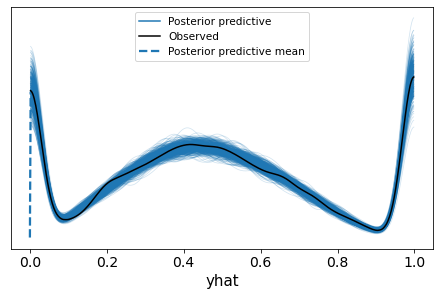

In [1198]:
posterior_samples = mcmc_test.get_samples()

posterior_predictive = Predictive(mixmodel_beta_custom3, posterior_samples)(
    random.PRNGKey(1), x
)

prior = Predictive(mixmodel_beta_custom3, num_samples=500)(
    random.PRNGKey(10), x
)

az_data2 = az.from_numpyro(mcmc_test, prior=prior, posterior_predictive=posterior_predictive)

az.plot_ppc(data=az_data2, var_names = "yhat", data_pairs={"yhat":"yhat"}, num_pp_samples=500)

In [1199]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.21      0.01     -0.21     -0.22     -0.19   6852.37      1.00
      beta      0.80      0.01      0.80      0.79      0.81   5958.10      1.00
         k     48.79      1.66     48.75     45.89     51.26   5670.50      1.00
      k_50    -11.27     14.52    -11.34    -34.61     13.19   6237.87      1.00
 mixing[0]      0.80      0.01      0.80      0.79      0.82   5617.00      1.00
 mixing[1]      0.10      0.01      0.10      0.09      0.11   5243.03      1.00
 mixing[2]      0.09      0.01      0.09      0.08      0.10   4873.38      1.00

Number of divergences: 0
